In [38]:
import re
import random
import math
import string
from collections import Counter
from functools import cache
import requests

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
TEXT = requests.get('https://norvig.com/big.txt').text
len(TEXT)

6488666

In [4]:
def tokens(text):
    return re.findall(r'[a-z]+', text.lower())

In [5]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [6]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [7]:
def sample(bag, n=10):
    return ' '.join(random.choice(bag) for _ in range(n))

In [8]:
sample(WORDS)

'holmes skill star nails able is states said death having'

In [9]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [10]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


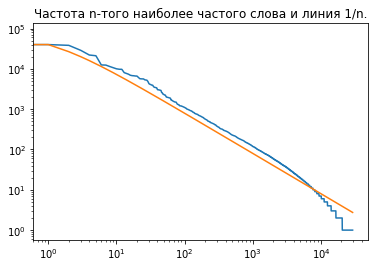

In [11]:
M = COUNTS.most_common(1)[0][1]
plt.yscale('log')
plt.xscale('log')
plt.title('Частота n-того наиболее частого слова и линия 1/n.')
plt.plot([c for (w, c) in COUNTS.most_common()])
plt.plot([M/i for i in range(1, len(COUNTS))])
pass

In [12]:
def splits(word):
    return [(word[:i], word[i:]) for i in range(len(word) + 1)]

def edits1(word):
    pairs = splits(word)
    deletes    = [a+b[1:]           for (a,b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a,b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a,b) in pairs for c in string.ascii_lowercase if b]
    inserts    = [a+c+b             for (a,b) in pairs for c in string.ascii_lowercase]
    return set(deletes + transposes + replaces + inserts)

In [13]:
[a+b[1:]           for (a,b) in splits('hello') if b]

['ello', 'hllo', 'helo', 'helo', 'hell']

In [14]:
splits('hello')

[('', 'hello'),
 ('h', 'ello'),
 ('he', 'llo'),
 ('hel', 'lo'),
 ('hell', 'o'),
 ('hello', '')]

In [15]:
def know(words):
    return {w for w in words if w in COUNTS}

def edits0(word):
    return {word}

def edits2(word):
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [16]:
def correct(word):
    candidates = (know(edits0(word)) or
                  know(edits1(word)) or
                  know(edits2(word)) or
                  [word])
    return max(candidates, key=COUNTS.get)

In [24]:
def case_of(text):
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

def correct_match(match):
    word = match.group()
    return case_of(word)(correct(word.lower()))

def correct_text(text):
    return re.sub('[a-zA-Z]+', correct_match, text)

In [25]:
correct_text('Speling Errurs IN somethink. Whutever; unusuael misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [27]:
def pdist(counter):
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

In [30]:
P = pdist(COUNTS)

In [31]:
for w in tokens('"The" is the most common word in English'):
    print(P(w), w)

0.07240666434449033 the
0.008842968103249388 is
0.07240666434449033 the
0.0008215075749693518 most
0.0002596615352601365 common
0.0002696137195383996 word
0.019949605757790978 in
0.00019090098933759167 english


In [32]:
def product(nums):
    result = 1
    for x in nums:
        result *= x
    return result

def Pwords(words):
    return product(P(w) for w in words)

In [35]:
tests = ['this is a test',
         'this is an unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

2.983396332800731e-11 this is a test
1.3975923769696695e-16 this is an unusual test
0.0 this is a neverbeforeseen test


In [37]:
max(len(w) for w in COUNTS)

18

In [41]:
def split_words(text, start=0, length=20):
    i_values = range(start, min(len(text) + 1, length))
    return [(text[:i], text[i:]) for i in i_values]

In [44]:
split_words('reallylong')

[('', 'reallylong'),
 ('r', 'eallylong'),
 ('re', 'allylong'),
 ('rea', 'llylong'),
 ('real', 'lylong'),
 ('reall', 'ylong'),
 ('really', 'long'),
 ('reallyl', 'ong'),
 ('reallylo', 'ng'),
 ('reallylon', 'g'),
 ('reallylong', '')]

In [45]:
@cache
def segment(text):
    if not text:
        return []
    candidates = ([first] + segment(rest) for (first, rest) in split_words(text, 1))
    return max(candidates, key=Pwords)

In [47]:
segment('reallylongtext')

['really', 'long', 'text']